
## Most Succesful Setup
- DenseNet121
- Optimizer: Adam
- Pretrain on images of 2015 competition 
        - im_size = 224
        - batch_size = 64
        - learning_rate = 5e-5
        - epochs = 20 
        - warmup_epochs = 2
        - warmup_batchsize = 128
        - warmup_lr = 1e-3
- Validate on 2019 images 
- Retrain and validate on 2019 images (15% validation Split)
- Custom Quadratic Kappa Callback
- Custom Image Generator (imgaug)
- Data Augmentation (Horizontal & Vertical Flips, Zoom, Crop...)

  
## Did not improve the LB score:
- Imagesize = 256, 320,  512
- Model = ResNet50, EfficientNetB3
- Cut uninformative black areas
- Add Ben Graham's filter
- Make a perfect circle crop
- Mixup images
- Transform to Multilabel problem (e.g. `[0,0,1,0]` --> `[1,1,1,0]`)
- Transform to Regression Problem (coeficients `[0.5, 1.5, 2.5, 3.5]`)
- Optimizers Adamax, Nadam
- Test Time Augmentation (x4, x5, x10)
- Increase batchsize to 64


## Still to try
- Ensemble
- SuperConvergence
- K-fold cross validation
- More image augmentations
- Resnet101, InceptionV3
- Different Top Architectures
- Label Smoothing

## Import Libraries

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score


%matplotlib inline

Using TensorFlow backend.


# Model Parameters

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

Set random seed for reproducibility.

In [3]:
np.random.seed(2019)
tf.set_random_seed(2019)

# Loading & Exploration

In [4]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print(f'Number of training examples: {train_df.shape[0]}')
print(f'Number of testing examples : {test_df.shape[0]}')
train_df.head()

Number of training examples: 3662
Number of testing examples : 1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

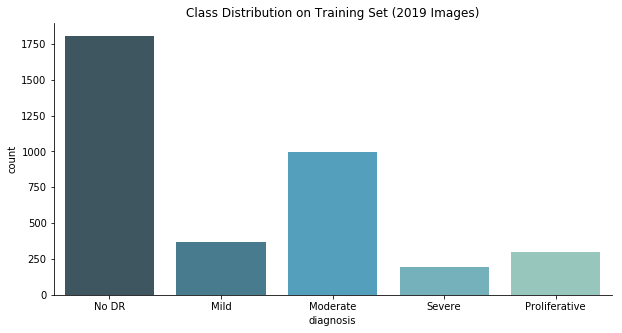

In [5]:
class_labels = { 0:  'No DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative'}
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.countplot(data=train_df, x='diagnosis', palette='GnBu_d')
ax.xaxis.set_ticklabels(class_labels.values())
plt.title('Class Distribution on Training Set (2019 Images)')
sns.despine()
plt.show()

In [6]:
def ClassDistribution(DataFrame):
    counts = DataFrame['diagnosis'].value_counts().sort_index()
    total = len(DataFrame)
    result = {}
    for label, count in counts.items():
        result[class_labels[label]] = round((count/total)*100, 1)
    return result 

train_dist = ClassDistribution(train_df)
for diagnosis, fraction in train_dist.items():
    print(f'{diagnosis} = {fraction}%')


No DR = 49.3%
Mild = 10.1%
Moderate = 27.3%
Severe = 5.3%
Proliferative = 8.1%


### Displaying some Sample Images

Text(0.5, 1.0, '224X224 (As seen by the network)')

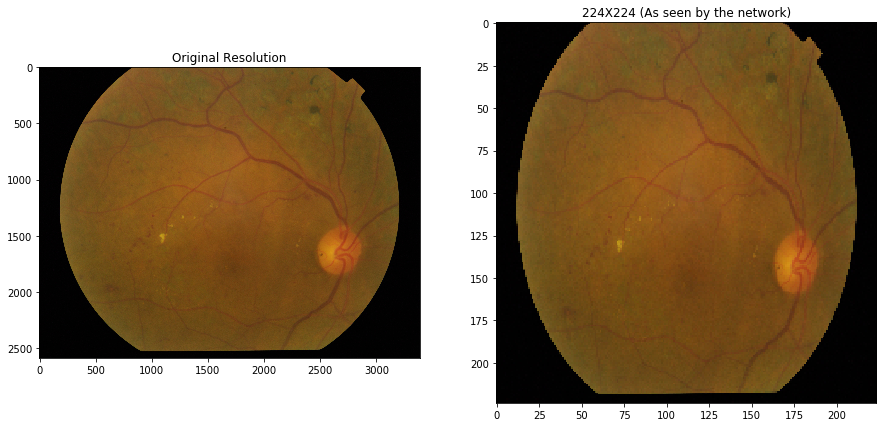

In [7]:
image_n = 5 #np.random.randint(len(train_df))
image1 = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{train_df["id_code"][image_n]}.png')[...,[2,1,0]]
image2 = cv2.resize(image1, (IMAGE_SIZE,)*2)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(image1)
plt.title(f'Original Resolution')

plt.subplot(1,2,2)
plt.imshow(image2)
plt.title(f'{IMAGE_SIZE}X{IMAGE_SIZE} (As seen by the network)')


Original image format (Training set):


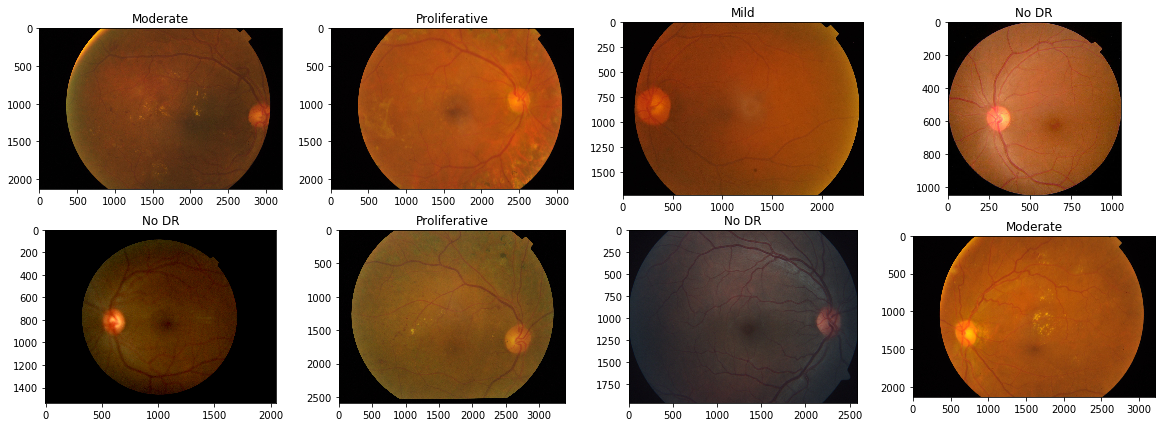

In [8]:
plt.figure(figsize=(20,7))
rows, columns = 2, 4
for i, image_code in enumerate(train_df['id_code'][:rows*columns], start=1):
    image = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(image_code))[...,[2, 1, 0]]
    plt.subplot(rows, columns, i)
    plt.imshow(image)
    diagnosis = train_df['diagnosis'][i-1]
    plt.title(class_labels[diagnosis])
print('Original image format (Training set):')

Resized (224x224):


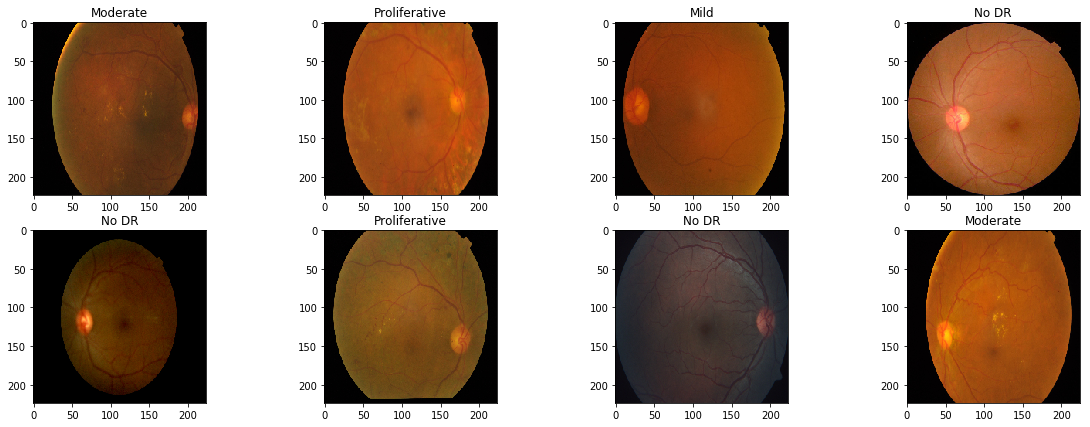

In [9]:
plt.figure(figsize=(20,7))
rows, columns = 2, 4
for i, image_code in enumerate(train_df['id_code'][:rows*columns], start=1):
    image = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(image_code))[...,[2, 1, 0]]
    image = cv2.resize(image, (224, 224))
    plt.subplot(rows, columns, i)
    plt.imshow(image)
    diagnosis = train_df['diagnosis'][i-1]
    plt.title(class_labels[diagnosis])
print('Resized (224x224):')

Original image format Test Set:


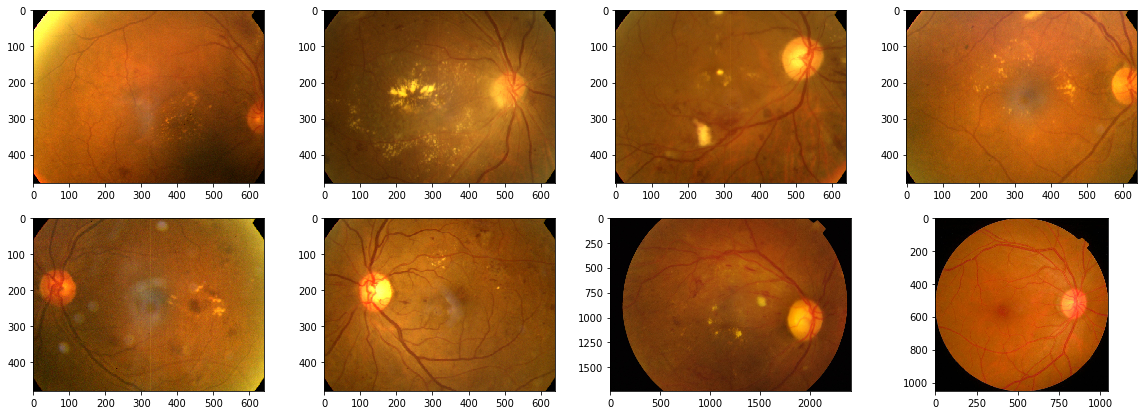

In [10]:
plt.figure(figsize=(20,7))
rows, columns = 2, 4
for i, image_code in enumerate(test_df['id_code'][:rows*columns], start=1):
    image = cv2.imread('../input/aptos2019-blindness-detection/test_images/{}.png'.format(image_code))[...,[2, 1, 0]]
    plt.subplot(rows, columns, i)
    plt.imshow(image)
print('Original image format Test Set:')

## Preprocess Images
Bellow are some of the different pre-processing methods tried. Currently none of them are in use becasue they haven't resulted in a better kappa score.

- Crop Black Areas.
- Add Ben's Filter.
- Make a perfect circle crop around the retina.
- Circle Crop + Ben's Filter


We will resize the images to 224x224, then create a single numpy array to hold the data.

In [11]:
def preprocess_image(image_path, desired_size=224):
    im = cv2.imread(image_path)
    im = cv2.resize(im, (desired_size, )*2)  
    return im


def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    
def ben_preprocess(path, IM_SIZE=IMAGE_SIZE):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IM_SIZE, IM_SIZE))
    image=cv2.addWeighted (image,4, # Add Ben Graham's Preprocessing Filter
                           cv2.GaussianBlur(image, (0,0), IM_SIZE/10),-4 ,128)
        
    return image


def circle_crop(path):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(path)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,)*2)

    return img 


def circle_crop_ben(path):   
    """
    Create circular crop around image centre  + Ben's Preprocessing  
    """    
    
    img = cv2.imread(path)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,)*2)
    img =cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , IMAGE_SIZE/10) ,-4 ,128)

    return img 

Crop:


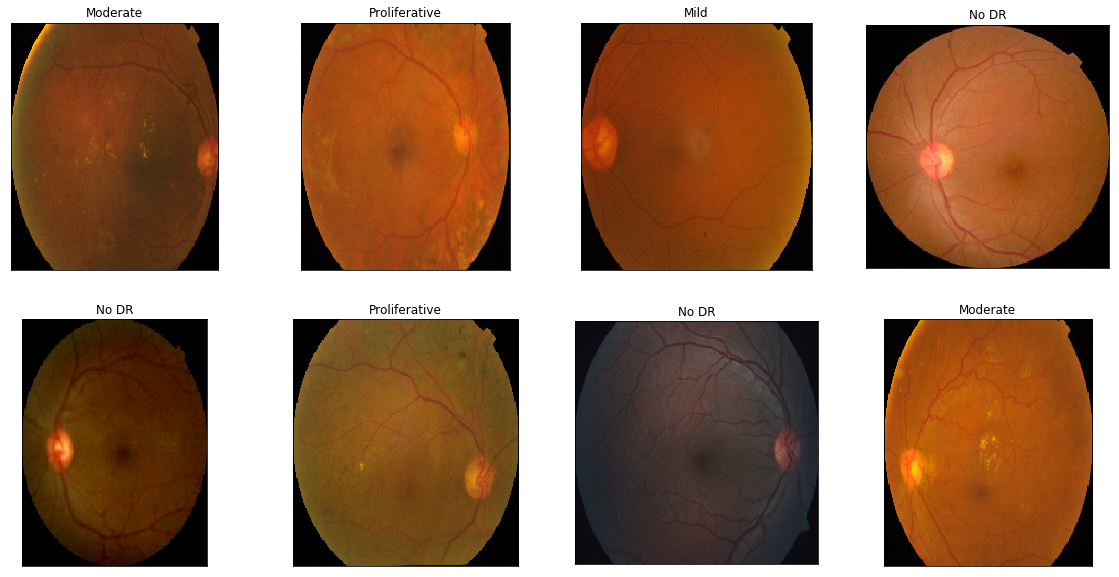

In [12]:
plt.figure(figsize=(20,10))
rows, columns = (2, 4) 
for i, image_code in enumerate(train_df['id_code'][:rows*columns], start=1):
    image = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_code}.png')[...,[2,1,0]]
    image = crop_image_from_gray(image)
    plt.subplot(rows, columns, i, yticks=[], xticks=[])
    plt.imshow(image)
    diagnosis = train_df['diagnosis'][i-1]
    plt.title(class_labels[diagnosis])
print("Crop:")

Ben Graham's Filter:


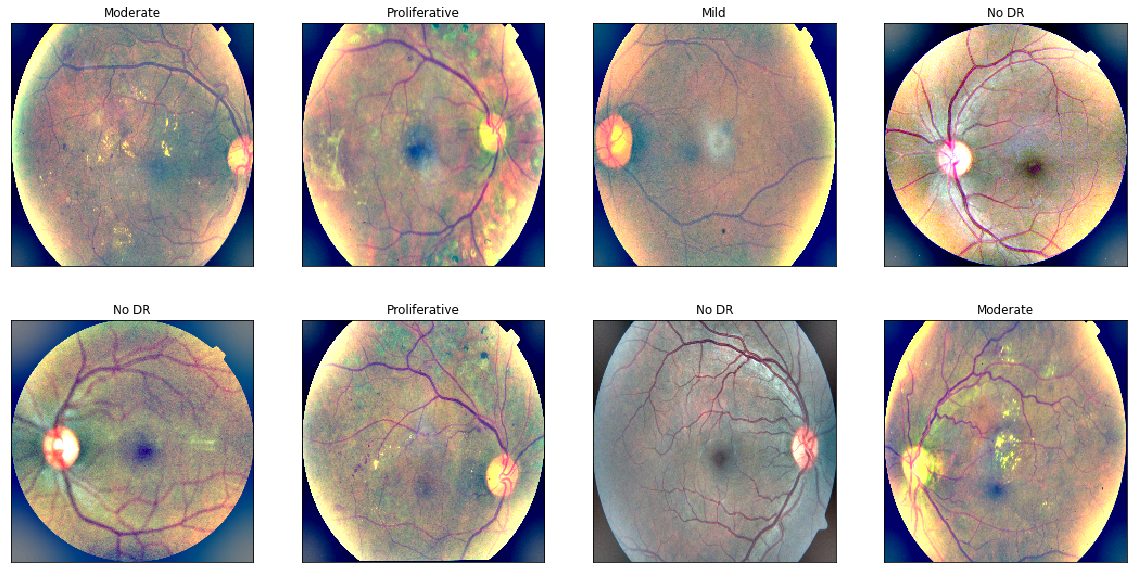

In [13]:
plt.figure(figsize=(20,10))
rows, columns = (2, 4) 
for i, image_code in enumerate(train_df['id_code'][:rows*columns], start=1):
    image = ben_preprocess(f'../input/aptos2019-blindness-detection/train_images/{image_code}.png')
    plt.subplot(rows, columns, i, yticks=[], xticks=[])
    plt.imshow(image)
    diagnosis = train_df['diagnosis'][i-1]
    plt.title(class_labels[diagnosis])
print("Ben Graham's Filter:")

Circle Crop:


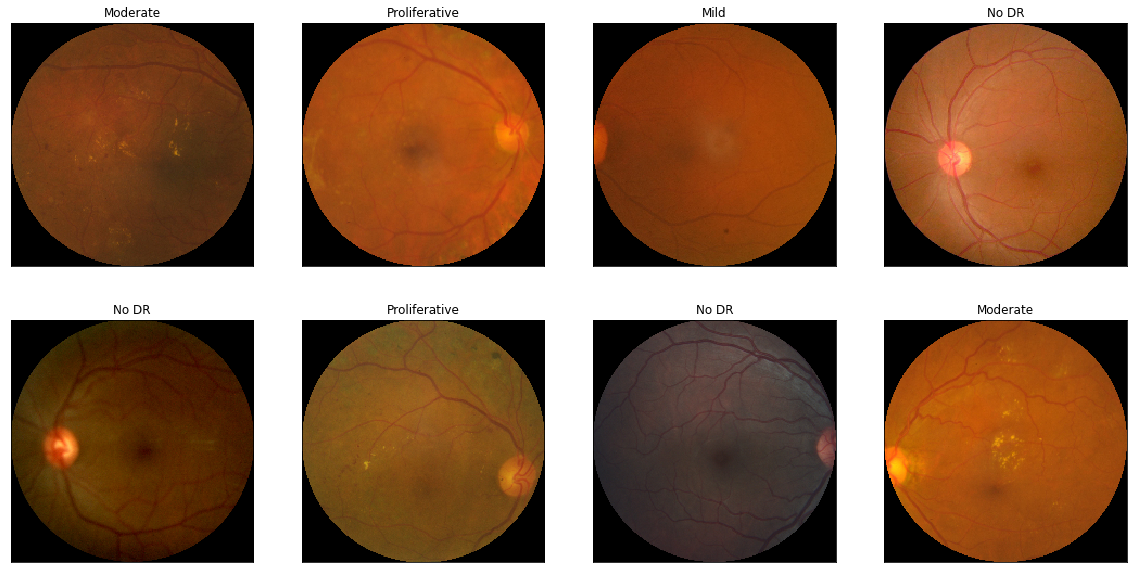

In [14]:
plt.figure(figsize=(20,10))
rows, columns = 2, 4
for i, image_code in enumerate(train_df['id_code'][:rows*columns], start=1):
    image = circle_crop(f'../input/aptos2019-blindness-detection/train_images/{image_code}.png')
    plt.subplot(rows, columns, i, yticks=[], xticks=[])
    plt.imshow(image)
    diagnosis = train_df['diagnosis'][i-1]
    plt.title(class_labels[diagnosis])
print('Circle Crop:')

Circle Crop + Ben Grahams Filter


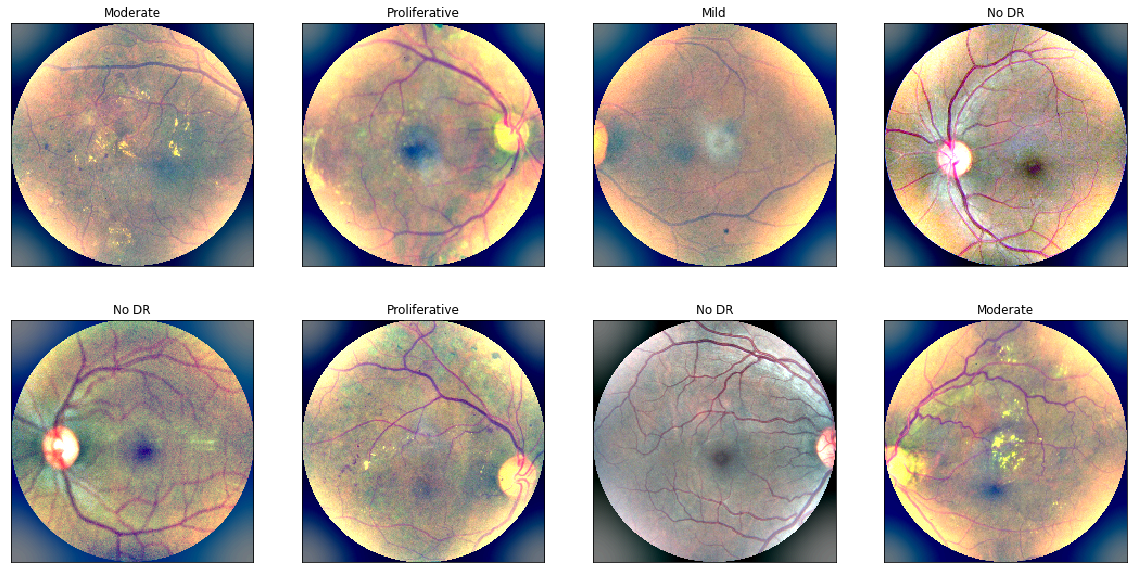

In [15]:
plt.figure(figsize=(20,10))
rows, columns = 2, 4
for i, image_code in enumerate(train_df['id_code'][:rows*columns], start=1):
    image = circle_crop_ben(f'../input/aptos2019-blindness-detection/train_images/{image_code}.png')
    plt.subplot(rows, columns, i, yticks=[], xticks=[])
    plt.imshow(image)
    diagnosis = train_df['diagnosis'][i-1]
    plt.title(class_labels[diagnosis])
print('Circle Crop + Ben Grahams Filter')

In [16]:
N = train_df.shape[0]
x_train = np.empty((N, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [04:14<00:00, 14.26it/s]


In [17]:
N = test_df.shape[0]
x_test = np.empty((N, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'../input/aptos2019-blindness-detection/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [00:45<00:00, 42.36it/s]


In [18]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [19]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state=2019
)

In [20]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.35,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

### Creating keras callback for QWK

In [21]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        
        def flatten(y):
            return np.argmax(y, axis=1).reshape(-1)
        
        y_val = flatten(y_val)
        y_pred = self.model.predict(X_val)
        y_pred = flatten(y_pred)

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Model: DenseNet-121

In [22]:
densenet = DenseNet121(
    weights=None,
    include_top=False,
    input_shape=(224,224,3)
)

In [23]:
def build_model():
    model = Sequential()    
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

model = build_model()
model.load_weights('../input/densenet121-pretrained-on-old/model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 8,092,229
Trainable params: 8,008,581
Non-trainable params: 83,648
_____________________________________________________________

# Training

In [24]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/15
98/97 [==============================] - 69s 703ms/step - loss: 0.6726 - acc: 0.7589 - val_loss: 0.4910 - val_acc: 0.8091
val_kappa: 0.8744
Validation Kappa has improved. Saving model.
Epoch 2/15
98/97 [==============================] - 34s 348ms/step - loss: 0.5475 - acc: 0.7921 - val_loss: 0.4386 - val_acc: 0.8327
val_kappa: 0.9062
Validation Kappa has improved. Saving model.
Epoch 3/15
98/97 [==============================] - 34s 349ms/step - loss: 0.4913 - acc: 0.8119 - val_loss: 0.4396 - val_acc: 0.8436
val_kappa: 0.8917
Epoch 4/15
98/97 [==============================] - 34s 349ms/step - loss: 0.4605 - acc: 0.8284 - val_loss: 0.4594 - val_acc: 0.8236
val_kappa: 0.8840
Epoch 5/15
98/97 [==============================] - 34s 345ms/step - loss: 0.4452 - acc: 0.8323 - val_loss: 0.4189 - val_acc: 0.8436
val_kappa: 0.9050
Epoch 6/15
98/97 [==============================] - 34s 348ms/step - loss: 0.4167 - acc: 0.8482 - val_loss: 0.4120 - val_acc: 0.8582
val_kappa: 0.9137
Vali

Text(0.5, 0, 'Epochs')

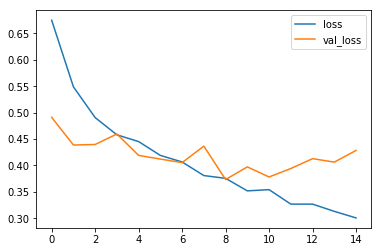

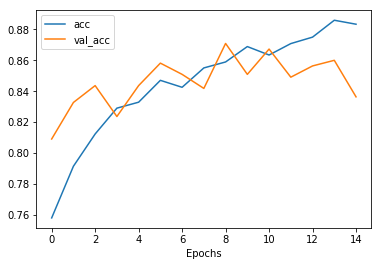

In [25]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
plt.xlabel('Epochs')

Text(0.5, 1.0, 'Quadratic Weighted Kappa')

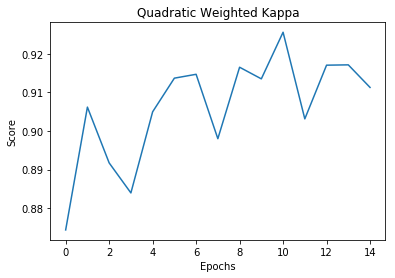

In [26]:
plt.plot(kappa_metrics.val_kappas)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Quadratic Weighted Kappa')

## Submit

In [27]:
model.load_weights('model.h5')

y_test = model.predict(x_test)
y_test = np.argmax(y_test, axis=1)

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv', index=False)